# Hydrological Data Colection Center
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 05-03-2024<br>

**Introduction:**<br>
This code downloads the reservoir time series available in the HYDRO data base.

In [208]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
import re
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Configuration

In [2]:
username = 'jesus.casado-rodriguez'
password = '#Urr13()u#'

PROVIDER_ID = 1088

url_API = 'https://ehdcc.soologic.com/wsOperational/webapi'

In [3]:
start = datetime(1979, 1, 2)
end = datetime.now().date()
strftime = '%Y-%m-%dT%H:%M:%S'

In [35]:
variables = {'O': 'outflow',
             'V': 'volume',
             # 'R': 'level'
            }

In [ ]:
path = Path('Z:/nahaUsers/casadje/datasets/hDMS/reservoirs')

## Reservoirs

Import CSV file of reservoirs in the Hydrological Data Colection Center (HDCC) database, fix some reservoir names and export it as a shapefile.

```Python
reservoirs = pd.read_csv(list(path.glob('*.csv'))[0], sep=';', index_col='EFAS_ID')

# correct reservoir names
names = []
for name in reservoirs.Name:
    name = name.upper()
    # remove code from reservoir name
    name = re.sub(r'E\d{2}\s*', '', name)
    # remove string 'embalse' from name
    name = re.sub(r'EMBALSE DE\s+', '', name)
    name = re.sub(r'EMBALSE DEL\s+', 'EL ', name)
    # remove string at the of the name
    name = re.sub(r'\s*\(PIE DE PRESA\)', '', name)
    # place articles ('el', 'la'...) at the beginning
    name = re.sub(r'(\w+), (\w+)', r'\2 \1', name)
    names.append(name)
reservoirs.Name = names

# convert into GeoDataFrame
geometry = [Point(xy) for xy in zip(reservoirs.Longitude_WGS84, reservoirs.Latitude_WGS84)]
reservoirs = gpd.GeoDataFrame(reservoirs, geometry=geometry, crs='epsg:4326')

print('total no. reservoirs:\t\t\t{0}'.format(reservoirs.shape[0]))

reservoirs.to_file('Z:/nahaUsers/casadje/datasets/hDMS/reservoirs/reservoirs.shp')
```

In [541]:
# import shapefile
hdcc = gpd.read_file('Z:/nahaUsers/casadje/datasets/hDMS/reservoirs/reservoirs.shp')
hdcc.set_index('EFAS_ID', drop=True, inplace=True)

# correct reservoir names
names = []
for name in hdcc.Name:
    name = name.upper()
    # remove code from reservoir name
    name = re.sub(r'E\d{2}\s*', '', name)
    # remove string 'embalse' from name
    name = re.sub(r'EMBALSE DE\s+', '', name)
    name = re.sub(r'EMBALSE DEL\s+', 'EL ', name)
    # remove string at the of the name
    name = re.sub(r'\s*\(PIE DE PRESA\)', '', name)
    # place articles ('el', 'la'...) at the beginning
    name = re.sub(r'(\w+), (\w+)', r'\2 \1', name)
    names.append(name)
hdcc.Name = names

# rename columns
hdcc.rename(columns={'Provider_I': 'Prov_ID'}, inplace=True)

# filter reservoirs from the Spanish Ministry
hdcc_es = hdcc.loc[hdcc['Country-Co'] == 'ES'].copy()
hdcc_es = hdcc.loc[hdcc.Prov_ID == '1088']

print(hdcc_es.shape)

(394, 141)


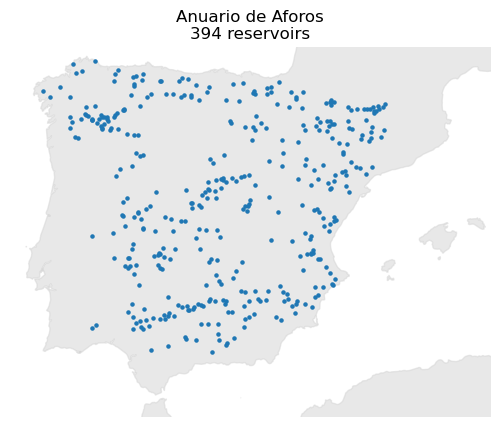

In [211]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
reservoirs_prov.plot(markersize=5, ax=ax)
ax.set_title(f'Anuario de Aforos\n{reservoirs_prov.shape[0]} reservoirs')
ax.set_extent([-10, 4.5, 35.5, 44])
ax.axis('off');

In [6]:
# summarize data availability
data_cols = reservoirs.columns.str.contains('[O|V|R]_Has_')
reservoirs_prov.loc[:, data_cols].sum()

O_Has_RTData         376
O_Has_historical     376
O_Has_Potentially      0
O_Has_Operative        0
R_Has_RTData           0
R_Has_historical       0
R_Has_Potentially      0
R_Has_Operative        0
V_Has_RTData         389
V_Has_historical     389
V_Has_Potentially      0
V_Has_Operative        0
dtype: object

Outflow ($O$) and volume ($V$) time series are available in 376 and 389 reservoirs, respectively. In both variables the number of reservoirs with real time and historical data are identical.

## Download data

In [7]:
start = datetime(1979, 1, 2)
end = datetime.now().date()
strftime = '%Y-%m-%dT%H:%M:%S'

### Data range

```Python
service = 'hdatarange'
url = f'{url_API}/{service}/'
response = requests.get(url + '9142', auth=requests.auth.HTTPBasicAuth(username, password))

if response.status_code == 200:
    data = response.json()
    # Do something with the data
else:
    print("Failed to retrieve data from the API")
```

In [8]:
date_cols = reservoirs.columns[reservoirs.columns.str.contains('Date_of_[Starting|Ending]')]
reservoirs_prov.shape[0] - reservoirs_prov.loc[:, date_cols].isnull().sum()

Date_of_Starting_Measurement       0
Date_of_Ending_Measurement         0
D_Date_of_Starting_Measurement     0
D_Date_of_Ending_Measurement       0
WL_Date_of_Starting_Measurement    0
WL_Date_of_Ending_Measurement      0
I_Date_of_Starting_Measurement     0
I_Date_of_Ending_Measurement       0
O_Date_of_Starting_Measurement     0
O_Date_of_Ending_Measurement       0
R_Date_of_Starting_Measurement     0
R_Date_of_Ending_Measurement       0
V_Date_of_Starting_Measurement     0
V_Date_of_Ending_Measurement       0
dtype: int64

All of the fields with beginning and end of the time series are empty.

### Near Real Time

In [9]:
# service = 'nrt'

# for ID in tqdm(reservoirs_prov.index, desc='Check availability of near real time data'):
#     url = f'{url_API}/{service}/{start.strftime(strftime)}/{end.strftime(strftime)}/{ID}/'
#     response = requests.get(url, auth=requests.auth.HTTPBasicAuth(username, password))
#     if response.status_code == 200:
#         print(ID)
#         break
#     else:
#         print(ID, response.status_code)

### Historic data

In [10]:
# service = 'historic'

# for ID in tqdm(reservoirs_prov.index, desc='Check availability of historic data'):
#     url = f'{url_API}/{service}/{start.strftime(strftime)}/{end.strftime(strftime)}/{ID}/'
#     response = requests.get(url, auth=requests.auth.HTTPBasicAuth(username, password))
#     if response.status_code != 404:
#         print(ID, url)
#         break
#     else:
#         print(ID, response.status_code)

### Operational

In [ ]:
# service = 'nhoperational24hw'

# dates = [date.date() for date in pd.date_range(start, end, periods=4)]

# path_out = path / service
# path_out.mkdir(parents=True, exist_ok=True)

# data = {var: {} for var in ['O', 'R', 'V']}
# for var, dct in tqdm(data.items(), desc='variable'):
#     for ID in tqdm(reservoirs_prov.index, desc='reservoir'):
#         if 'serie' in locals():
#             del serie
#         serie = pd.Series(dtype=float)
#         for i, (st, en) in enumerate(zip(dates[:-1], dates[1:])):
#             if i > 0:
#                 st += timedelta(days=1)
#             url = f'{url_API}/{service}/{st.strftime(strftime)}/{en.strftime(strftime)}/{ID}/{var}/'
#             response = requests.get(url, auth=requests.auth.HTTPBasicAuth(username, password))
#             if response.status_code == 200:
#                 df_i = pd.DataFrame(response.json())
#                 if df_i.shape[0] > 0:
#                     serie_i = df_i[['Timestamp', 'AvgValue']].set_index('Timestamp', drop=True).AvgValue
#                     serie_i.index = pd.to_datetime(serie_i.index)
#                     serie = pd.concat((serie, serie_i), axis=0)
#         if serie.shape[0] > 0:
#         #    df.to_csv(path_out / f'{ID}.csv', index=False)
#             dct[ID] = serie.sort_index().copy()

In [ ]:
# # convert to an xarray.Dataset and export a NetCDF file per reservoir
# ds = xr.Dataset({variables[var]: xr.DataArray(pd.DataFrame(series), dims=['date', 'ID'], name=variables[var]) for var, series in data.items() if len(series) > 0})
# for ID in ds.ID.data:
#     ds.sel(ID=ID).to_netcdf(path_out / f'{ID}.nc')

***

In [34]:
service = 'nhoperational24hw'

dates = [date.date() for date in pd.date_range(start, end, periods=4)]

path_out = path / service
path_out.mkdir(parents=True, exist_ok=True)

for ID in tqdm(reservoirs_prov.index, desc='reservoir'):
    
    file_out = path_out / f'{ID}.nc'
    if file_out.exists():
        continue
    
    # download data
    data = {}
    for var, variable in variables.items():
        if 'serie' in locals():
            del serie
        serie = pd.DataFrame(columns=[ID], dtype=float)
        for i, (st, en) in enumerate(zip(dates[:-1], dates[1:])):
            if i > 0:
                st += timedelta(days=1)           
            url = f'{url_API}/{service}/{st.strftime(strftime)}/{en.strftime(strftime)}/{ID}/{var}/'
            response = requests.get(url, auth=requests.auth.HTTPBasicAuth(username, password))
            if response.status_code == 200:
                serie_i = pd.DataFrame(response.json())
                if serie_i.shape[0] > 0:
                    serie_i = serie_i[['Timestamp', 'AvgValue']].set_index('Timestamp', drop=True)
                    serie_i.index = pd.to_datetime(serie_i.index)
                    serie_i.columns = [ID]
                    serie = pd.concat((serie, serie_i), axis=0)
        if serie.shape[0] > 0:
            data[variable] = serie.sort_index().copy()
    
    # convert to xarray.Dataset
    data = xr.Dataset({var: xr.DataArray(serie, dims=['date', 'ID']) for var, serie in data.items()})
    # export as NetCDF
    data.to_netcdf(file_out)

reservoir:   0%|          | 0/394 [00:00<?, ?it/s]

## ICOLD

Import Excel file with the complete ICOLD data set, do some changes and export as a shapefile.

```Python

# import ICOLD dataset
icold = pd.read_excel('Z:/nahaUsers/casadje/datasets/reservoirs/ICOLD/2023/ICOLD_2023_global.xlsx', decimal=',')

# rename columns
rename_columns = {#'Altitude', 
                  'Area of Reservoir': 'Res_Area', 
                  'Catchment area': 'Catch_Area', 
                  # 'Comms1', 
                  # 'Comms2',
                  # 'Comms3', 
                  # 'Consultant', 
                  # 'Continent', 
                  # 'Contractor', 
                  # 'Country',
                  'Dam Type': 'Dam_Type', 
                  'Detailed Type': 'Dam_Type2', 
                  'Electric Capacity': 'Elec_Capac', 
                  # 'Foundation',
                  # 'Height', 
                  'International': 'Internatio', 
                  'International Code': 'Int_Code', 
                  'Irrigated area': 'Irr_Area',
                  # 'Latitude', 
                  'Length of crest': 'Crest_Leng', 
                  'Length of Reservoir': 'Res_Leng', 
                  # 'Longitude',
                  'Main Dam': 'Dam_Main', 
                  'Mean Annual Energy': 'Ene_Annual', 
                  'Name of the dam': 'Dam_Name', 
                  'Nearest Town': 'Near_Town',
                  # 'Note', 
                  'Other Name': 'Other_Name', 
                  # 'Owner', 
                  # 'Particular', 
                  # 'Purposes',
                  'Reservoir Capacity': 'Res_Vol', 
                  'Reservoir Name': 'Res_Name', 
                  'Resettlement': 'Resettled', 
                  # 'River',
                  # 'Sealing', 
                  'Second Dam': 'Dam_Second', 
                  'Spillway Capacity': 'Spill_Cap', 
                  'Spillway Type': 'Spill_Type',
                  'State / Province / Country': 'State', 
                  'Volume Flood Protection': 'Vol_flood',
                  'Volume of dam body': 'Dam_Volume', 
                  'Year of Completion': 'Year'
                 }
icold.rename(columns=rename_columns, inplace=True)
icold.sort_index(axis=1, inplace=True)

# convert units to MCM (hm3)
icold.Res_Vol /= 1000

# convert to geopandas
geometry = [Point(xy) for xy in zip(icold['Longitude'], icold['Latitude'])]
icold = gpd.GeoDataFrame(icold, geometry=geometry, crs='epsg:4326')
# export shapefile
icold.to_file('Z:/nahaUsers/casadje/datasets/reservoirs/ICOLD/2023/ICOLD_global.shp')

```

***

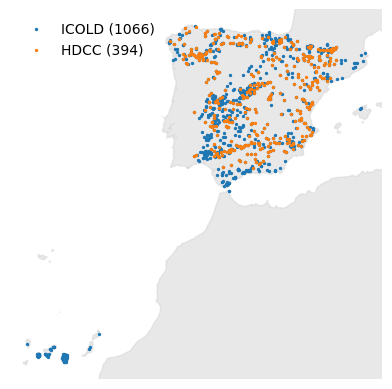

In [531]:
# import shapefile
icold_es = gpd.read_file('Z:/nahaUsers/casadje/datasets/reservoirs/ICOLD/2023/ICOLD_ES.shp')
icold_es.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
icold_es.plot(markersize=2, ax=ax, label=f'ICOLD ({icold_es.shape[0]})')
hdcc.plot(markersize=2, ax=ax, label=f'HDCC ({hdcc.shape[0]})')
# ax.set_extent([-10, 4.5, 35.5, 44])
ax.legend(frameon=False)
ax.axis('off');

In [534]:
# convert units to MCM (hm3)
icold_es.Res_Vol /= 1000

mask_volume = icold_es.Res_Vol > 10
print(f'no. reservoirs in Spain with V > 100 hm3:\t{mask_volume.sum()}')

no. reservoirs in Spain with V > 100 hm3:	367


***

In [535]:
# nearest neighbour in ICOLD for each point in HDCC
idx_hdcc, idx_icold = icold_es.sindex.nearest(hdcc.geometry, max_distance=.05)

idx_hdcc = hdcc.index[idx_hdcc]
hdcc.loc[idx_hdcc, 'ICOLD_ID'] = icold_es.iloc[idx_icold]['Int_Code'].values
hdcc.loc[idx_hdcc, 'ICOLD_Name'] = icold_es.iloc[idx_icold]['Res_Name'].values

In [539]:
mask_name = hdcc.Name != hdcc.ICOLD_Name
hdcc.loc[mask_name, ['Name', 'ICOLD_Name']]

,Name,ICOLD_Name
EFAS_ID,,
9134,URDON,NaN
9135,CAMARMEÑA,NaN
9136,ARENAS DE CABRALES,NaN
9144,MIRANDA,NaN
9148,RIO COBO,NaN
9186,VILL / MAO /REGUEIRO,EDRADA-MAO
9205,MONCABRIL (SISTEMA),CARDENA
9307,PUENTE NAVARRO,NaN
9359,LA FRESNEDA (AZUD),NaN


There are still 19 reservoirs that not much between ICOLD and HDCC.